In [1]:
import torch
import gym
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
eps = np.finfo(np.float32).eps.item()
torch.manual_seed(100)

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, h_size):
        super(PolicyNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, h_size),
            nn.Dropout(p = 0.6),
            nn.ReLU(),
            nn.Linear(h_size, 2)
        )
    def forward(self, x):
        score = self.linear_relu_stack(x)
        probs = F.softmax(score, dim = 1)
        return probs

In [3]:
class ValueNetwork(nn.Module):
    def __init__(self, h_size):
        super(ValueNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, h_size),
            nn.Dropout(p = 0.6),
            nn.ReLU(),
            nn.Linear(h_size,1)
        )
    def forward(self, x):
        value = self.linear_relu_stack(x)
        return value

In [4]:
class Reinforce:
    def __init__(self, gamma, h_size):
        self.env = gym.make("CartPole-v1")
        self.policy = PolicyNetwork(h_size)
        self.value = ValueNetwork(h_size)
        self.max_ep_steps = 10000
        self.gamma = gamma
    def collect_episode(self):
        obs = self.env.reset()
        r = []
        logp = []
        values = []
        for i in range(0,self.max_ep_steps):
            obs = torch.from_numpy(obs).float().unsqueeze(0)
            values.append(self.value(obs))
            probs = self.policy(obs)
            m = torch.distributions.Categorical(probs = probs)
            action = m.sample()
            logp.append(m.log_prob(action))
            obs, rew, done, info = self.env.step((action.item()))
            r.append(rew)
            if done:
                break
        g = [0]
        for rew in reversed(r):
            g = [rew + self.gamma*g[0]] + g
        g = g[0:-1]
        g = torch.tensor(g)
       # g = (g - g.mean()) / (g.std() + eps)
        return logp, g, sum(r), values
    def show_progress(self):
        obs = self.env.reset()
        for i in range(0,1000):
            obs = torch.from_numpy(obs).float().unsqueeze(0)
            probs = self.policy(obs)
            m = torch.distributions.Categorical(probs = probs)
            action = m.sample()
            obs, rew , done ,info = self.env.step(action.item())
            self.env.render()

In [8]:
def run(vanilla_pgradient,learning_rate, fig_file_name, avg_reward_file_name, model_file_name):
    optimizer_policy = optim.Adam(vanilla_pgradient.policy.parameters(), lr=learning_rate)
    optimizer_value = optim.Adam(vanilla_pgradient.value.parameters(), lr=1e-1)
    ep_rew = []
    running_reward = 10
    avg_rewards = []
    for i in range(0,20000):
        logp, g, r, values = vanilla_pgradient.collect_episode()
      #  print(logp)
      #  print(g)
      #  return
        policy_loss = 0
        value_loss = 0
        for log_p, R , value in zip(logp, g, values):
            policy_loss = policy_loss - log_p*(R - value.detach().numpy())
            #print(log_p)
            #print(R)
            #eturn
            #print(value)
            #print(value.detach())
            #return
        n = 0
        for R , value in zip(g, values):
            value_loss = value_loss + (R - value)**2
            n = n+1
        value_loss = value_loss/n
        #for Gt, Vs in zip(g, values):
            #value_loss = value_loss + (Gt-Vs)**2
        optimizer_policy.zero_grad()
        optimizer_value.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        optimizer_policy.step()
        optimizer_value.step()
        running_reward = 0.05 * r + (1 - 0.05) * running_reward
        avg_rewards.append(running_reward)
        if(running_reward > vanilla_pgradient.env.spec.reward_threshold):
            print("solved")
            break
        if(i % 10 == 0):
            print(f'episode: {i}\t ep_reward: {r:.2f}\t average_reward: {running_reward:.2f}')
        #print("logp\n", logp)
        #print("g\n", g)
        ep_rew.append(r)
        del logp[:]
    #vanilla_pgradient.show_progress()
    vanilla_pgradient.env.close()
    plt.plot(avg_rewards)
    plt.title("average reward")
    plt.xlabel("episodes")
    plt.ylabel("average reward")
    plt.savefig(fig_file_name)
    plt.show()
    np.savetxt(avg_reward_file_name, avg_rewards, fmt='%f')
    plt.close('all')
    print(vanilla_pgradient.env.spec.reward_threshold)
    torch.save(vanilla_pgradient.policy,model_file_name)
    return avg_rewards
h_size = 64
rew99 = run(Reinforce(.99, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}.pt")
rew95 = run(Reinforce(.95, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}.pt")
rew100 = run(Reinforce(1.0, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}.pt")

tensor([-0.7294], grad_fn=<SqueezeBackward1>)
tensor(15.7057)
tensor([-0.6251], grad_fn=<SqueezeBackward1>)
tensor(10.2465)
tensor([-0.4900], grad_fn=<SqueezeBackward1>)
tensor(18.)


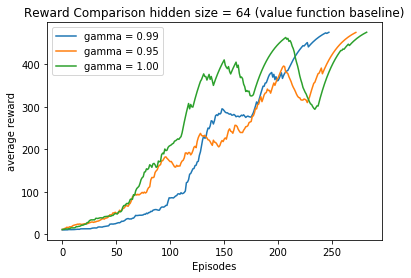

In [6]:
plt.plot(rew99, label='gamma = 0.99')
plt.plot(rew95, label='gamma = 0.95')
plt.plot(rew100, label='gamma = 1.00')
plt.title("Reward Comparison hidden size = 64 (value function baseline)")
plt.xlabel("Episodes")
plt.ylabel("average reward")
plt.legend()
plt.savefig("reward_comparison_h_size_64")
plt.show()
plt.close('all')

episode: 0	 ep_reward: 16.00	 average_reward: 10.30
episode: 10	 ep_reward: 18.00	 average_reward: 12.59
episode: 20	 ep_reward: 14.00	 average_reward: 14.63
episode: 30	 ep_reward: 13.00	 average_reward: 16.15
episode: 40	 ep_reward: 14.00	 average_reward: 21.54
episode: 50	 ep_reward: 25.00	 average_reward: 21.56
episode: 60	 ep_reward: 22.00	 average_reward: 20.11
episode: 70	 ep_reward: 10.00	 average_reward: 17.65
episode: 80	 ep_reward: 14.00	 average_reward: 16.86
episode: 90	 ep_reward: 24.00	 average_reward: 16.53
episode: 100	 ep_reward: 29.00	 average_reward: 18.74
episode: 110	 ep_reward: 12.00	 average_reward: 22.00
episode: 120	 ep_reward: 18.00	 average_reward: 25.06
episode: 130	 ep_reward: 55.00	 average_reward: 32.03
episode: 140	 ep_reward: 74.00	 average_reward: 41.26
episode: 150	 ep_reward: 57.00	 average_reward: 42.37
episode: 160	 ep_reward: 23.00	 average_reward: 51.78
episode: 170	 ep_reward: 73.00	 average_reward: 53.80
episode: 180	 ep_reward: 52.00	 average

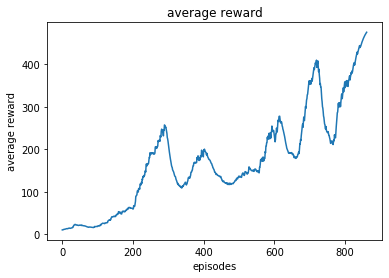

475.0
episode: 0	 ep_reward: 34.00	 average_reward: 11.20
episode: 10	 ep_reward: 31.00	 average_reward: 19.36
episode: 20	 ep_reward: 30.00	 average_reward: 21.52
episode: 30	 ep_reward: 26.00	 average_reward: 30.53
episode: 40	 ep_reward: 50.00	 average_reward: 42.22
episode: 50	 ep_reward: 20.00	 average_reward: 42.12
episode: 60	 ep_reward: 88.00	 average_reward: 50.66
episode: 70	 ep_reward: 41.00	 average_reward: 60.94
episode: 80	 ep_reward: 188.00	 average_reward: 90.02
episode: 90	 ep_reward: 239.00	 average_reward: 121.64
episode: 100	 ep_reward: 220.00	 average_reward: 157.89
episode: 110	 ep_reward: 183.00	 average_reward: 179.52
episode: 120	 ep_reward: 143.00	 average_reward: 180.53
episode: 130	 ep_reward: 302.00	 average_reward: 194.77
episode: 140	 ep_reward: 176.00	 average_reward: 245.88
episode: 150	 ep_reward: 164.00	 average_reward: 209.08
episode: 160	 ep_reward: 185.00	 average_reward: 187.67
episode: 170	 ep_reward: 371.00	 average_reward: 207.74
episode: 180	 

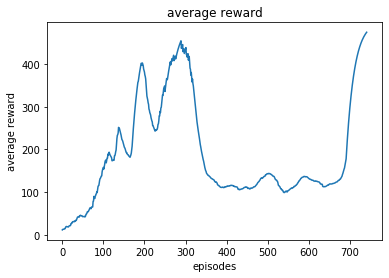

475.0
episode: 0	 ep_reward: 47.00	 average_reward: 11.85
episode: 10	 ep_reward: 21.00	 average_reward: 16.17
episode: 20	 ep_reward: 58.00	 average_reward: 22.32
episode: 30	 ep_reward: 24.00	 average_reward: 31.53
episode: 40	 ep_reward: 81.00	 average_reward: 39.78
episode: 50	 ep_reward: 34.00	 average_reward: 41.27
episode: 60	 ep_reward: 87.00	 average_reward: 56.67
episode: 70	 ep_reward: 41.00	 average_reward: 72.11
episode: 80	 ep_reward: 154.00	 average_reward: 95.01
episode: 90	 ep_reward: 228.00	 average_reward: 136.61
episode: 100	 ep_reward: 122.00	 average_reward: 191.32
episode: 110	 ep_reward: 404.00	 average_reward: 215.03
episode: 120	 ep_reward: 471.00	 average_reward: 249.73
episode: 130	 ep_reward: 162.00	 average_reward: 244.08
episode: 140	 ep_reward: 146.00	 average_reward: 228.96
episode: 150	 ep_reward: 500.00	 average_reward: 300.30
episode: 160	 ep_reward: 500.00	 average_reward: 367.84
episode: 170	 ep_reward: 268.00	 average_reward: 355.05
episode: 180	 

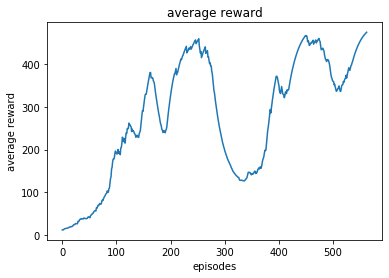

475.0


In [20]:
torch.manual_seed(100)
h_size = 64
rew99 = run(Reinforce(.99, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}.pt")
rew95 = run(Reinforce(.95, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}.pt")
rew100 = run(Reinforce(1.0, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}.pt")

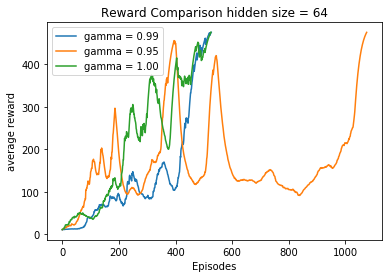

In [12]:
plt.plot(rew99, label='gamma = 0.99')
plt.plot(rew95, label='gamma = 0.95')
plt.plot(rew100, label='gamma = 1.00')
plt.title("Reward Comparison hidden size = 64")
plt.xlabel("Episodes")
plt.ylabel("average reward")
plt.legend()
plt.savefig("reward_comparison_h_size_64")
plt.show()
plt.close('all')

episode: 0	 ep_reward: 18.00	 average_reward: 10.40
episode: 10	 ep_reward: 15.00	 average_reward: 14.56
episode: 20	 ep_reward: 31.00	 average_reward: 17.78
episode: 30	 ep_reward: 16.00	 average_reward: 17.08
episode: 40	 ep_reward: 14.00	 average_reward: 16.04
episode: 50	 ep_reward: 26.00	 average_reward: 17.66
episode: 60	 ep_reward: 24.00	 average_reward: 18.82
episode: 70	 ep_reward: 23.00	 average_reward: 20.89
episode: 80	 ep_reward: 57.00	 average_reward: 29.03
episode: 90	 ep_reward: 33.00	 average_reward: 29.50
episode: 100	 ep_reward: 14.00	 average_reward: 36.68
episode: 110	 ep_reward: 33.00	 average_reward: 41.64
episode: 120	 ep_reward: 118.00	 average_reward: 51.06
episode: 130	 ep_reward: 125.00	 average_reward: 58.08
episode: 140	 ep_reward: 287.00	 average_reward: 86.17
episode: 150	 ep_reward: 53.00	 average_reward: 97.85
episode: 160	 ep_reward: 114.00	 average_reward: 100.89
episode: 170	 ep_reward: 45.00	 average_reward: 93.38
episode: 180	 ep_reward: 118.00	 a

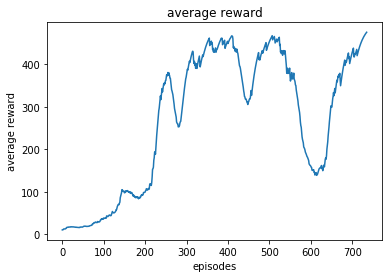

475.0
episode: 0	 ep_reward: 21.00	 average_reward: 10.55
episode: 10	 ep_reward: 10.00	 average_reward: 14.87
episode: 20	 ep_reward: 33.00	 average_reward: 19.26
episode: 30	 ep_reward: 74.00	 average_reward: 28.13
episode: 40	 ep_reward: 27.00	 average_reward: 30.34
episode: 50	 ep_reward: 42.00	 average_reward: 40.37
episode: 60	 ep_reward: 20.00	 average_reward: 41.84
episode: 70	 ep_reward: 26.00	 average_reward: 42.48
episode: 80	 ep_reward: 16.00	 average_reward: 47.92
episode: 90	 ep_reward: 112.00	 average_reward: 57.86
episode: 100	 ep_reward: 46.00	 average_reward: 60.81
episode: 110	 ep_reward: 34.00	 average_reward: 54.36
episode: 120	 ep_reward: 95.00	 average_reward: 54.86
episode: 130	 ep_reward: 24.00	 average_reward: 63.32
episode: 140	 ep_reward: 75.00	 average_reward: 76.76
episode: 150	 ep_reward: 118.00	 average_reward: 92.40
episode: 160	 ep_reward: 175.00	 average_reward: 122.92
episode: 170	 ep_reward: 121.00	 average_reward: 128.66
episode: 180	 ep_reward: 26

In [13]:
h_size = 32
rew99 = run(Reinforce(.99, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.99_h_size_{h_size}.pt")
rew95 = run(Reinforce(.95, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_0.95_h_size_{h_size}.pt")
rew100 = run(Reinforce(1.0, h_size), 1e-2, f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}.png", f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}", f"cartpole_v_1_policy_grad_normalized_return_gamme_1.00_h_size_{h_size}.pt")
plt.plot(rew99, label='gamma = 0.99')
plt.plot(rew95, label='gamma = 0.95')
plt.plot(rew100, label='gamma = 1.00')
plt.title("Reward Comparison hidden size = 32")
plt.xlabel("Episodes")
plt.ylabel("average reward")
plt.legend()
plt.savefig("reward_comparison_h_size_64")
plt.show()
plt.close('all')